In [1]:
%load_ext autoreload
%autoreload 2
import bayes3d as b3d
import bayes3d.genjax
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s
# console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(0)

In [3]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
import numpy as np


fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)

ps = jax.vmap(lift_pose)(_xs, _hds)


mesh = trimesh_from_2d_segs(_segs)
table   = create_cuboid(20, 20, -0.1)
table   = move_to_xy(table, *_center)
mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

v = Viewer(cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(mesh.vertices, mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))

for p in ps: v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 128, 1024)


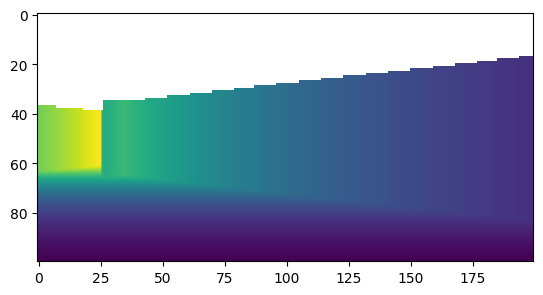

In [4]:
intrinsics = b3d.Intrinsics(
    height=100,
    width=200,
    fx=100.0, fy=100.0,
    cx=100.0, cy=50.0,
    near=0.01, far=20.0
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([mesh, table]), center_mesh=False)


def render(p):
    return b3d.RENDERER.render(b3d.t3d.inverse_pose(p)[None,...], jnp.array([0]))

img = render(ps[1])
img_ = img[:,:,2].at[img[:,:,3]==0].set(jnp.nan)

# -----------------
plt.imshow(img_)

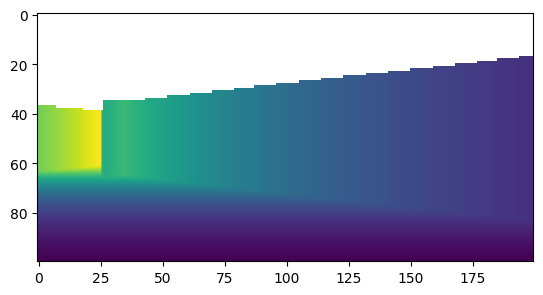

In [8]:
np.save("./data/test_imgs/img_1", img_)

im = np.load("./data/test_imgs/img_1.npy")
# -----------------
plt.imshow(im)

In [9]:
for t in range(10):
    img = render(ps[t])
    img_ = img[:,:,2].at[img[:,:,3]==0].set(jnp.nan)
    np.save(f"./data/test_imgs/img_{t}", img_)
    
    

In [4]:
zs_ = np.array(img).reshape(-1,4)
zs = zs_[zs_[:,3]==1] 

view = np.array([
    [1.0,   0.0,   0.0],
    [ 0.0,   -1.0,  0.0],
    [ 0.0,   0.0,   -1.0]
])
v = Viewer(cam_pos=(0,0,-5), cam_look=np.array([0,0,0]), background="#eee", view=view)
v.add_points(zs[:,:3], c=zs[:,2], s=.5)
v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


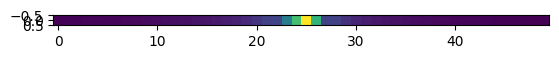

In [5]:
intrinsics = b3d.Intrinsics(
    height=1,
    width=50,
    fx=10.0, fy=1.0,
    cx=25.0, cy=0.0,
    near=0.01, far=20.0
)
# intrinsics = b3d.Intrinsics(
#     height=100,
#     width=200,
#     fx=20.0, fy=20.0,
#     cx=100.0, cy=50.0,
#     near=0.01, far=20.0
# )

# intrinsics = b3d.Intrinsics(
#     height=10,
#     width=20,
#     fx=20.0, fy=20.0,
#     cx=10.0, cy=5.0,
#     near=0.01, far=20.0
# )

# intrinsics = b3d.Intrinsics(
#     height=10,
#     width=20,
#     fx=20.0, fy=20.0,
#     cx=10.0, cy=5.0,
#     near=0.01, far=20.0
# )
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([mesh, table]), center_mesh=False)


t = 20
p = ps[t]
x,r = unpack_pose(p)

img = render(p)
img_ = img[:,:,2].at[img[:,:,3]==0].set(jnp.nan)

# -----------------
plt.imshow(img_)

In [63]:
import time 

def cache_last(f):
    last_h   = None
    last_ret = None

    def g(*args, **kwargs):
        nonlocal last_h, last_ret;

        h = hash(
            (tuple(args), tuple(kwargs.items()))
        )

        if last_h == h:
            return last_ret
        else:
            last_h = h
            last_ret = f(*args, **kwargs)
            return last_ret
    return g

@cache_last
def f(x):
    time.sleep(1)
    return x

for i in range(3): print(f(1))

1
1
1


In [70]:
def render(p, renderer):
    return renderer.render(b3d.t3d.inverse_pose(p)[None,...], jnp.array([0]))

@cache_last
def make_the_map(intrinsics):
    the_map = b3d.renderer.Renderer(intrinsics)
    the_map.add_mesh(trimesh.util.concatenate([mesh, table]), center_mesh=False)
    return the_map


intrinsics = b3d.Intrinsics(
        height=10,
        width=20,
        fx=20.0, fy=20.0,
        cx=10.0, cy=5.0,
        near=0.01, far=20.0
)

@genjax.gen
def model():
    
    p = b3d.genjax.uniform_pose(
        jnp.ones(3) * -100.0,
        jnp.ones(3) * 100.0,
    ) @ "agent_pose"

    the_map = make_the_map(intrinsics)
    rendered = render(p, the_map)[...,:3]
   
    variance      = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "outlier_prob"

    image         = b3d.genjax.image_likelihood(rendered, variance, outlier_prob, 20.0) @ "imgage"
    return p, rendered, image


enumerator, enumerator_score, enumerator_parallel, enumerator_score_parallel = b3d.genjax.make_enumerator(["agent_pose"])

In [71]:
key, tr = model.simulate(key, ())

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (32, 32, 1024)


In [76]:
key, = jax.random.split(key, 1)
ch  =  genjax.choice_map({
        "agent_pose": ps[0],
        "variance": 0.1,
        "outlier_prob": 0.1,
})
model_args= ()
key, (w, tr) = model.importance(key, ch, model_args);

ch = genjax.choice_map({"agent_pose": ps[3]})
diffs = tuple(map(lambda v: Diff(v, UnknownChange), tr.args))

tr_ = tr.update(key, ch, diffs)[1][2]


%timeit -n 1 -r 1 enumerator_score_parallel(tr, key, ps)

1.86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [68]:
zs  = np.array(img.reshape(-1,4))
zs_ = zs[zs[:,3]==1]

v = Viewer(cam_pos=np.array([x[0],x[1],10]), cam_look=np.array([x[0],x[1],0]), background="#eee", view_as="world")
v._v._light2.intensity = .9


v.add_mesh(mesh.vertices, mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
v.add_points(np.array(apply_pose(p, zs_[:,:3])), c=zs_[:,2], s=1.)
v.add_pose(p, scale=0.5, width=2)
v


NameError: name 'img' is not defined

In [126]:
@genjax.gen
def model():
    p = b3d.genjax.uniform_pose(
        jnp.ones(3) * -100.0,
        jnp.ones(3) * 100.0,
    ) @ "agent_pose"

    rendered = render(p)[...,:3]
   
    variance      = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.0001, 0.1) @ "outlier_prob"
    image         = b3d.genjax.image_likelihood(rendered, variance, outlier_prob, 20.0) @ "image"
    return p, rendered, image


In [127]:
enumerator, enumerator_score, enumerator_parallel, enumerator_score_parallel = b3d.genjax.make_enumerator(["agent_pose"])

In [128]:
def _eval_pose(trace, key, pose):
    ch = genjax.choice_map({"agent_pose": pose})
    diffs = tuple(map(lambda v: Diff(v, UnknownChange), trace.args))

    return trace.update(key, ch, diffs)[1][2].get_score()

eval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0)))
lift_poses = jax.jit(jax.vmap(lift_pose))

-66.163574 *


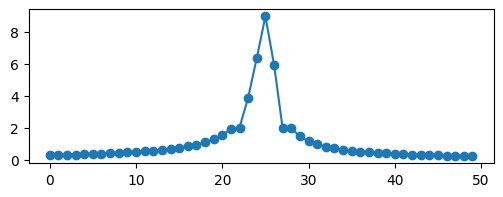

In [129]:
t0 = 20
p0 = ps[t0]

key, = jax.random.split(key, 1)
ch  =  genjax.choice_map({
        "agent_pose": p0,
        "variance": 0.1,
        "outlier_prob": 0.1,
})
model_args= ()

(key, (_, tr0))= model.importance(key, ch, model_args)

# ---------------------------
print(tr0.get_score(), "*")
plt.figure(figsize=(6,2))
plt.plot(tr0["image"][0,:,2], marker="o")

In [44]:
sc = eval_poses(tr0, key, ps)
sc = enumerator_score_parallel(tr0, key, ps)

In [45]:
def vector_grid(v0, shape, r, flat=False):
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)



deg = 20
r  = jnp.array([0.2,0.2,jnp.pi/180*deg])
k  = jnp.array([4, 4, 360//deg])
v0 = jnp.array([0.0,0.0,0.0])


vs = vector_grid(v0, k, r, flat=True)
qs = lift_poses(vs[:,:2], vs[:,2])


print(vs.shape)
print(qs.shape)

(288, 3)
(288, 4, 4)


In [99]:
_T

50

In [133]:
t0 = 0
p0 = ps[t0]

key, = jax.random.split(key, 1)
ch  =  genjax.choice_map({
        "agent_pose": p0,
        "variance": 0.1,
        "outlier_prob": 0.1,
})
model_args= ()

(key, (_, tr0))= model.importance(key, ch, model_args)


```
Peak buffers:
	Buffer 1:
		Size: 41.91GiB
		Operator: op_name="jit(enumerator_score)/jit(main)/sub" source_file="/home/ubuntu/workspace/bayes3d/bayes3d/likelihood.py" source_line=186
		XLA Label: fusion
		Shape: f32[100,200,22500,5,5]
```

(6000, 4, 4)
10 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.82 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


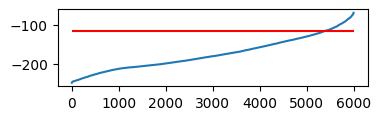

In [150]:
x_noise  = 0.3
hd_noise = np.pi/180*20

deg = 4
r  = jnp.array([0.1,0.1,deg/180*jnp.pi])
shape = jnp.array([20, 20, 15])
v0 = jnp.array([
     _xs[t0,0] + np.random.normal()*x_noise,
     _xs[t0,1] + np.random.normal()*x_noise,
    _hds[t0]
])


vs = vector_grid(v0, shape, r, flat=True)
qs = lift_poses(vs[:,:2], vs[:,2])

print(qs.shape)
key = jax.random.split(key, 1)[0]
sc = enumerator_score_parallel(tr0, key, qs)
order = np.argsort(sc)

key = jax.random.split(key, 1)[0]
%timeit -n 1 -r 1 vector_grid(v0, shape, r, flat=True);
%timeit -n 1 -r 1 lift_poses(vs[:,:2], vs[:,2])
%timeit -n 1 -r 1 enumerator_score_parallel(tr0, key, qs)

# ------------------------
plt.figure(figsize=(4,1))
plt.plot(sc[order])
plt.hlines(jnp.quantile(sc, 0.9), 0, len(sc), color="red")

In [153]:
sc_ = jnp.clip(sc,jnp.quantile(sc, 0.95), jnp.max(sc))
cs = plt.cm.viridis(plt.Normalize()(sc_))

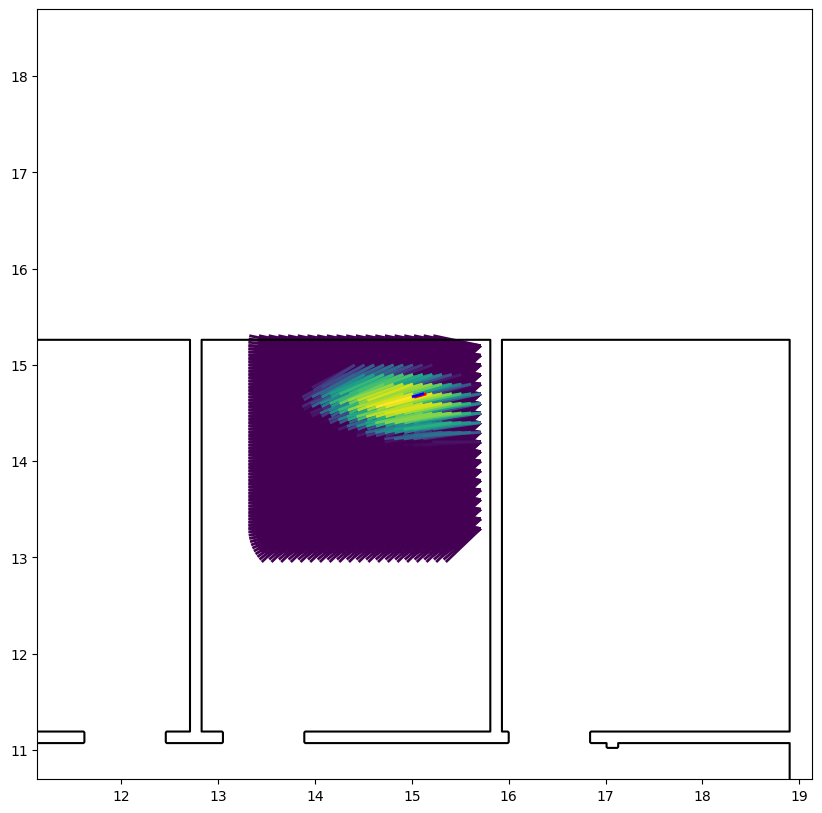

In [156]:
a = qs[order,:2,3]
b = a + 0.5*qs[order,:2,2]
lines = np.column_stack((a, b)).reshape(-1, 2, 2)
lc = LineCollection(lines, colors=cs[order], linewidths=2)


# -------------------
plt.figure(figsize=(10,10))
PAD = 4
plt.xlim( _xs[t0,0] - PAD, _xs[t0,0] + PAD)
plt.ylim( _xs[t0,1] - PAD, _xs[t0,1] + PAD)

plt.gca().add_collection(lc)
plt.plot(*_verts.T, c="k")

x, r = unpack_pose(p0)
plt.plot([x[0], x[0] + 0.1*r[0,2]],[x[1],x[1] + 0.1*r[1,2]], c="red", linewidth=2);

x, r = unpack_pose(qs[order[-1]])
plt.plot([x[0], x[0] + 0.1*r[0,2]],[x[1],x[1] + 0.1*r[1,2]], c="blue", linewidth=2);